In [1]:
import h5py
import pickle
import numpy as np

## Load Dataset

In [2]:
# training data
h5f = h5py.File('dataset/train_data.h5', 'r')
x_train = h5f['x_train'][:]
y_train = h5f['y_train'][:]
h5f.close()

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)

x_train: (100, 250, 250, 3)
y_train: (100, 16)


In [3]:
# validation data
h5f = h5py.File('dataset/val_data.h5', 'r')
x_val = h5f['x_val'][:]
y_val = h5f['y_val'][:]
h5f.close()

print('x_val:', x_val.shape)
print('y_val:', y_val.shape)

x_val: (50, 250, 250, 3)
y_val: (50, 16)


## Load vocabulary and embeddings

In [4]:
def read_glove_vecs(glove_file):
    print('Creating word to vec map...')
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float32)
    print('Done!')
    return word_to_vec_map

In [5]:
# load embeddings
word_to_vec_map = read_glove_vecs('{}/glove.6B.100d.txt'.format('dataset'))

Creating word to vec map...
Done!


In [6]:
# assign embeddings values to tokens
size = word_to_vec_map['unk'].shape

word_to_vec_map['<sos>'] = np.random.uniform(low=-1.0, high=1.0, size=size)
word_to_vec_map['<eos>'] = np.random.uniform(low=-1.0, high=1.0, size=size)
word_to_vec_map['<pad>'] = np.random.uniform(low=-1.0, high=1.0, size=size)

In [7]:
# load vocabulary
with open('dataset/vocabulary.pickle', 'rb') as vocab_file:
    vocabulary_dict = pickle.load(vocab_file)

vocabulary = vocabulary_dict['vocabulary']
word_to_index = vocabulary_dict['word_to_index']
index_to_word = vocabulary_dict['index_to_word']

# number of words in vocabulary
num_words = len(vocabulary)

## Training Data

In [8]:
# input to encoder is the numpy array of the image
encoder_input_data = x_train
encoder_input_data_val = x_val

In [9]:
# input and output data for the decoder is identical, except shifted one time-step

# training
decoder_input_data = y_train[:, :-1]
decoder_output_data = y_train[:, 1:]

# validation
decoder_input_data_val = y_val[:, :-1]
decoder_output_data_val = y_val[:, 1:]

## Define Image Model (Encoder)

In [10]:
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.layers import Conv2D, Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding

from capsule_layers import CapsuleLayer, PrimaryCap, Length

Using TensorFlow backend.


In [ ]:
tf.reset_default_graph()
K.clear_session()

In [11]:
def connect_encoder(encoder_input, num_caption_caps, routings):
    """ Create the encoder model
        @params:
        :encoder_input -- input tensor for the image to be given to the capsnet model
        :num_caption_caps -- number of capsules in caption caps layer
        :routings -- number of routings in the dynamic routing algorithm
        
        @return:
        :encoder_output -- output of the capsnet model
    """
    
    # Layers 1-3: Three conventional Conv2D layers
    conv1 = Conv2D(filters=96, kernel_size=13, strides=4, padding='valid', activation='relu', name='conv1')(encoder_input)
    conv2 = Conv2D(filters=96, kernel_size=5, strides=2, padding='valid', activation='relu', name='conv2')(conv1)
    conv3 = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv3')(conv2)
    
    # Layer 4: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primary_caps = PrimaryCap(conv3, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 5: Capsule layer. Routing algorithm works here.
    caption_caps = CapsuleLayer(num_capsule=num_caption_caps, dim_capsule=16, routings=routings, name='caption_caps')(primary_caps)

    encoder_output = Length(name='capsnet')(caption_caps)
    
    return encoder_output

In [12]:
encoder_input_shape = x_train.shape[1:]  # (img_size, img_size, channels)
num_caption_caps = 20  # Number of capsules in caption caps layer
routings = 3

In [13]:
# placeholder for input image
encoder_input = Input(shape=encoder_input_shape, name='encoder_input')

In [14]:
# output of capsnet
encoder_output = connect_encoder(encoder_input, num_caption_caps, routings)

## Define caption model (Decoder)

In [15]:
def create_embedding_layer(word_to_index, word_to_vec_map, num_words):
    """ Create a Keras Embedding() layer and load in pre-trained GloVe 100-dimensional vectors
        @params:
        :word_to_index -- dictionary containing the each word mapped to its index
        :word_to_vec_map -- dictionary mapping words to their GloVe vector representation
        :num_words -- number of words in the vocabulary
        
        @return:
        :decoder_embedding -- pretrained layer Keras instance
    """
    
    vocabulary_length = num_words + 1  # adding 1 to fit Keras embedding (requirement)
    embedding_dimensions = word_to_vec_map['unk'].shape[0]  # define dimensionality of GloVe word vectors (= 100)
    
    embedding_matrix = np.zeros((vocabulary_length, embedding_dimensions))  # initialize with zeros
    for word, index in word_to_index.items():
        try:
            embedding_matrix[index, :] = word_to_vec_map[word]
        except KeyError:
            embedding_matrix[index, :] = word_to_vec_map['unk']
    
    # we don't want the embeddings to be updated, thus trainable parameter is set to False
    decoder_embedding = Embedding(vocabulary_length, embedding_dimensions, trainable=False)
    decoder_embedding.build((None,))
    decoder_embedding.set_weights([embedding_matrix])  # with this the layer is now pretrained
    
    return decoder_embedding

In [16]:
# internal state size of LSTM layers in the RNN
state_size = 512

# The ouput of the encoder is given to the LSTM as an initial state,
# so the dimensions of the encoder_output and decoder_initial_hidden_state must match.
# Thus, a fully-connected layer is used to map the vectors from num_caption_caps to state_size elements.
decoder_transfer_map = Dense(state_size, activation='tanh', name='decoder_transfer_map')

# initial states for the LSTM cells
decoder_initial_hidden_state = Input(shape=(state_size,), name='decoder_initial_hidden_state')  # encoder ouput
decoder_initial_cell_state = Input(shape=(state_size,), name='decoder_initial_cell_state')

# input for the token sequences to the decoder
# using 'None' in the shape means that the token-sequences can have arbitrary lengths
decoder_input = Input(shape=(None,), name='decoder_input')

# pretrained embedding layer
decoder_embedding = create_embedding_layer(word_to_index, word_to_vec_map, num_words)

# LSTM layers of the decoder
lstm1 = LSTM(state_size, return_sequences=True, name='lstm1')
lstm2 = LSTM(state_size, return_sequences=True, name='lstm2')
lstm3 = LSTM(state_size, return_sequences=True, name='lstm3')

# output of the decoder model
# the activation-function is set to 'linear' because there is a bug in Keras
# so a custom loss-function has to be made, which is done below
decoder_dense = Dense(num_words, activation='linear', name='decoder_output')

In [17]:
# fully-connected layer form of the encoder output
dense_encoder_output = decoder_transfer_map(encoder_output)

In [18]:
def connect_decoder(hidden_state, cell_state):
    """ Create the decoder model
        @params:
        :hidden_state -- hidden state of the lstm, can be the output of the encoder
        :cell_state -- cell state of the lstm
        :model_type -- specifies whether to apply the transfer map on the hidden state
        
        @return:
        :decoder_output -- output of the RNN model
    """
    
    # Layer 1: embedding layer
    decoder_network = decoder_embedding(decoder_input)
    
    # Layers 2-4
    decoder_network = lstm1(decoder_network, initial_state=[hidden_state, cell_state])
    decoder_network = lstm2(decoder_network, initial_state=[hidden_state, cell_state])
    decoder_network = lstm3(decoder_network, initial_state=[hidden_state, cell_state])
    
    # Connect the final dense layer that converts to one-hot encoded arrays
    decoder_output = decoder_dense(decoder_network)
    
    return decoder_output

In [19]:
# Model 1
decoder_output = connect_decoder(
    hidden_state=dense_encoder_output,
    cell_state=decoder_initial_cell_state
)

model_train = Model(
    inputs=[encoder_input, decoder_input, decoder_initial_cell_state],
    outputs=[decoder_output]
)

In [20]:
# Model 2
model_encoder = Model(inputs=[encoder_input], outputs=[dense_encoder_output])

In [21]:
# Model 3
decoder_output = connect_decoder(
    hidden_state=decoder_initial_hidden_state,
    cell_state=decoder_initial_cell_state
)

model_decoder = Model(
    inputs=[decoder_input, decoder_initial_hidden_state, decoder_initial_cell_state],
    outputs=[decoder_output]
)

In [22]:
model_train.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 60, 60, 96)   48768       encoder_input[0][0]              
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 28, 28, 96)   230496      conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 20, 20, 256)  1990912     conv2[0][0]                      
__________________________________________________________________________________________________
primarycap

In [23]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [24]:
optimizer = RMSprop(lr=1e-3)

# There is a bug in Keras due to which it cannot automatically deduce the correct shape of decoder's output data.
# We therefore need to manually create a placeholder variable for the decoder's output.
# The shape is set to (None, None) which means the batch can have an arbitrary number of sequences,
# which can have an arbitrary number of integer-tokens.
decoder_target = K.placeholder(dtype='int64', shape=(None, None))

In [25]:
model_train.compile(
    optimizer=optimizer,
    loss=sparse_cross_entropy,
    target_tensors=[decoder_target]
)

## Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

In [26]:
# callback for writing checkpoints during training
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(
    filepath=path_checkpoint,
    monitor='val_loss',
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

In [27]:
# callback for stopping the optimization when performance worsens on the validation-set
callback_early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [28]:
# callback for writing the TensorBoard log during training
callback_tensorboard = TensorBoard(log_dir='./logs/', histogram_freq=0, write_graph=False)

In [29]:
callbacks = [callback_early_stopping, callback_checkpoint, callback_tensorboard]

## Train model

### Load checkpoint

In [31]:
try:
    model_train.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = 'checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


### Begin Training

In [32]:
x_data = {
    'encoder_input': encoder_input_data,
    'decoder_input': decoder_input_data,
    'decoder_initial_cell_state': np.zeros((x_train.shape[0], state_size))
}

y_data = {
    'decoder_output': decoder_output_data
}

In [33]:
x_data_val = {
    'encoder_input': encoder_input_data_val,
    'decoder_input': decoder_input_data_val,
    'decoder_initial_cell_state': np.zeros((x_val.shape[0], state_size))
}

y_data_val = {
    'decoder_output': decoder_output_data_val
}

In [34]:
model_train.fit(
    x=x_data,
    y=y_data,
    batch_size=5,  # correct the batch_size on big dataset
    epochs=10,
    callbacks=callbacks,
    validation_data=(x_data_val, y_data_val)
)

Train on 100 samples, validate on 50 samples
Epoch 1/10
100/100 [==============================] - 24s 242ms/step - loss: 5.9881 - val_loss: 4.9263

Epoch 00001: val_loss improved from inf to 4.92634, saving model to checkpoint.keras
Epoch 2/10
100/100 [==============================] - 19s 195ms/step - loss: 4.4319 - val_loss: 4.7171

Epoch 00002: val_loss improved from 4.92634 to 4.71710, saving model to checkpoint.keras
Epoch 3/10
100/100 [==============================] - 20s 196ms/step - loss: 4.1008 - val_loss: 4.7148

Epoch 00003: val_loss improved from 4.71710 to 4.71483, saving model to checkpoint.keras
Epoch 4/10
100/100 [==============================] - 20s 198ms/step - loss: 3.9172 - val_loss: 4.7046

Epoch 00004: val_loss improved from 4.71483 to 4.70464, saving model to checkpoint.keras
Epoch 5/10
100/100 [==============================] - 20s 198ms/step - loss: 3.8148 - val_loss: 5.0697

Epoch 00005: val_loss did not improve from 4.70464
Epoch 6/10
100/100 [============

## Generate Captions

In [39]:
import cv2
import matplotlib.pyplot as plt

from utils import load_image

In [44]:
def generate_caption(image_path, max_tokens=16):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    img = load_image(image_path, size=x_train.shape[1:3], color=True)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(img, axis=0)

    # Process the image with the pre-trained image-model
    encoder_output = model_encoder.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int64)

    # The first input-token is the special start-token for 'ssss '.
    token_int = word_to_index['<sos>']
    
    token_end = word_to_index['<eos>']

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for '<eos>'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = {
            'decoder_input': decoder_input_data,
            'decoder_initial_hidden_state': encoder_output,
            'decoder_initial_cell_state': np.zeros((1, state_size))
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the LSTM-states when calling predict() and then
        # feeding these LSTM-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = model_decoder.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        # Note that this is not limited by softmax, but we just
        # need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = index_to_word[token_int]

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(img)  # display in RGB format
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    print(output_text)
    print()

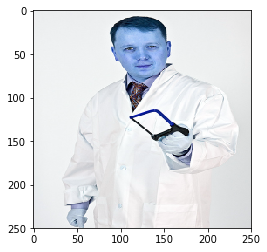

Predicted caption:
 a woman of a a a a a a <eos>



In [45]:
generate_caption("dataset/val2017/000000289229.jpg")